<a href="https://colab.research.google.com/github/tripidhoble/Hackathon-Projects/blob/master/MFC_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install pyspellchecker

     |████████████████████████████████| 1.9MB 4.9MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [0]:
#import important libraries
from spellchecker import SpellChecker

In [0]:
path = "drive/My Drive/data/"

customer_df = pd.read_csv(path + 'customer.csv')
invoice_df = pd.read_csv(path + 'invoice.csv')
jtd_df = pd.read_csv(path + 'jtd.csv')
plant_df = pd.read_csv(path + 'plant.csv')
vehicles_df = pd.read_csv(path + 'vehicles.csv')

In [0]:
# 1. drop unwanted columns from all dataframes
# 2. lowercase all the categorical columns

def drop_col(dataset, col_to_drop):
    dataset.drop(col_to_drop, axis=1, inplace=True)
    return dataset

def lowercase(dataset):
    categorical_col = dataset.select_dtypes(exclude=['number']).columns
    for col in categorical_col:
        dataset[col] = dataset[col].map(lambda x: x if type(x)!=str else x.lower())
    return dataset

invoice_columns_to_drop = ['Unnamed: 0', 'Amt Rcvd From Custom', 'Amt Rcvd From Ins Co','Area / Locality',
                           'CGST(14%)', 'CGST(2.5%)', 'CGST(6%)', 'CGST(9%)',
                           'IGST(12%)', 'IGST(18%)', 'IGST(28%)', 'IGST(5%)', 'Insurance Company',
                           'Outstanding Amt', 'SGST/UGST(14%)', 'SGST/UGST(2.5%)', 'SGST/UGST(6%)', 'SGST/UGST(9%)',
                           'Service Advisor Name', 'TDS amount', 'Total CGST', 'Total GST', 'Total IGST',
                           'Total SGST/UGST','Plant Name1','Recovrbl Exp']
customer_columns_to_drop = ['Unnamed: 0','Death date']
plant_columns_to_drop = ['Unnamed: 0','Name 1','Factory calendar','Valuation Area',
                         'Customer no. - plant','PO Box','Postal Code','Name 2',
                         'Vendor number plant','House number and street']
jtd_columns_to_drop = ['Unnamed: 0']
vehicles_columns_to_drop = ['Unnamed: 0','Product GUID']

dataframes = [invoice_df, customer_df, plant_df, jtd_df, vehicles_df]
dataframe_columns_to_drop = [invoice_columns_to_drop, customer_columns_to_drop, plant_columns_to_drop, jtd_columns_to_drop, vehicles_columns_to_drop]

for i in range(len(dataframes)):
  dataframes[i] = drop_col(dataframes[i],dataframe_columns_to_drop[i])
  dataframes[i] = lowercase(dataframes[i])

In [0]:

# Preprocessing for dataset merge operation

# 1. Remove leading zeros from 'Customer No.' column
def remove_leading_zeros(dataset,cols):
    for col in cols:
      dataset[col] = dataset[col].astype(str).apply(lambda x: x.lstrip("0"))
    return dataset
invoice_df  = remove_leading_zeros(invoice_df,['Customer No.'])
customer_df = remove_leading_zeros(customer_df,['Customer No.'])


# 2. Rename columns to use them as key column for merge operation
def rename_columns(dataset, rename_cols_dict):
    dataset.rename(columns=rename_cols_dict, inplace=True)
    return dataset
dict_invoice_df = {'District':'State'}
dict_vehicles_df = {'Vehicle Model':'Make', 'License Plate Number':'Regn No'}

invoice_df  = rename_columns(invoice_df, dict_invoice_df)
vehicles_df = rename_columns(vehicles_df, dict_vehicles_df)


# 3. Replace values in key columns for merge operation
def replacement(dataset, col, dict_replacement, regex=False):
    dataset[col] = dataset[col].replace(dict_replacement, regex=regex )
    return dataset
make_replacements = {
                    'mahindra &  mahindra': 'mahindra',
                    'tata motors': 'tata',
                    'maruti suzuki': 'maruti',
                    'mercedes benz': 'mercedes-benz',
                    'porche': 'porsche',
                    'land rover' : 'rover',
                    'mitsubishi motors':'mitsubishi motor',
                    'premier\xa0automobiles': 'premierauto'
                    }
pattern_replacement = {'z_':''}
vehicles_df = replacement(vehicles_df, 'Make', pattern_replacement, regex=True)
vehicles_df = replacement(vehicles_df, 'Make', make_replacements)
invoice_df  = replacement(invoice_df, 'Make', make_replacements)

In [0]:
# Merge dataframes based on key
def merge_df(left_df, right_df, key):
    merge_df = pd.merge(left=left_df, right=right_df, how='left', on=key)
    return merge_df

invoice_customer_df = merge_df(left_df=invoice_df, right_df=customer_df,key=['Customer No.'])
invoice_customer_plant_df = merge_df(left_df=invoice_customer_df, right_df=plant_df,key=['Plant','State'])
invoice_customer_plant_vehicles_df = merge_df(left_df=invoice_customer_plant_df, right_df=vehicles_df,key=['Regn No','Make'])

master_df = invoice_customer_plant_vehicles_df

In [11]:
print("invoice_df shape: ",invoice_df.shape)
print("customer_df shape: ",customer_df.shape)
print("invoice_customer_df shape: ",invoice_customer_df.shape)
print("plant_df shape: ",plant_df.shape)
print("invoice_customer_plant_df shape: ",invoice_customer_plant_df.shape)
print("vehicles_df shape: ",vehicles_df.shape)
print("invoice_customer_plant_vehicles_df shape: ",invoice_customer_plant_vehicles_df.shape)

invoice_df shape:  (984741, 33)
customer_df shape:  (555338, 8)
invoice_customer_df shape:  (984741, 40)
plant_df shape:  (438, 4)
invoice_customer_plant_df shape:  (984741, 42)
vehicles_df shape:  (588761, 3)
invoice_customer_plant_vehicles_df shape:  (992903, 43)


In [0]:
# fill missing values of 'CITY' column 
master_df['CITY'].fillna(master_df['City'], inplace = True)

#remove dulicate column 'City'
master_df = drop_col(dataset=master_df, col_to_drop=['City'])

In [13]:
# Function to identify the number of missing values in every feature
def missing_datas(dataset):
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = ((dataset.isnull().sum())*100/dataset.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
    
missing_data_master_df = missing_datas(master_df)
print("missing data for 'master_df': ")
print(missing_data_master_df[missing_data_master_df['Percent']>0.00])

missing_data_jtd_df = missing_datas(jtd_df)
print("missing data for 'jtd_df': ")
print(missing_data_jtd_df[missing_data_jtd_df['Percent']>0.00])

missing data for 'master_df': 
                      Total    Percent
Claim No.            988053  99.511533
Occupation           965665  97.256731
Cash /Cashless Type  965197  97.209597
Date of Birth        962418  96.929710
Marital Status       958174  96.502277
Gate Pass Date       946518  95.328345
Policy no.           924141  93.074651
Expiry Date          894807  90.120284
Technician Name      734250  73.949822
ODN No.              690834  69.577189
Total Value          690834  69.577189
Sales organization   279168  28.116342
Title                152663  15.375419
Fuel Type             21738   2.189338
Data Origin            7627   0.768152
Partner Type           5489   0.552823
Business Partner       3510   0.353509
Regn No                3315   0.333869
Model                  1736   0.174841
Cust Type                 4   0.000403
CITY                      3   0.000302
missing data for 'jtd_df': 
                       Total    Percent
Labor Value Number   3774033  67.159778
Tar

In [0]:
# Function to drop missing values
def drop_missing(dataset, missing, min_threshold, max_threshold):
    dataset = dataset.drop((missing[missing['Percent'] > max_threshold]).index,axis= 1)
    dataset = dataset.dropna(axis=0, subset=(missing[missing['Percent'] < min_threshold]).index)
    return dataset 

master_df  = drop_missing(master_df,missing_data_master_df,2,40)
jtd_df     = drop_missing(jtd_df,missing_data_jtd_df,2,40)

In [15]:
#recheck the missing values
new_missing_data = missing_datas(master_df)
print("missing data for 'master_df'")
print(new_missing_data[new_missing_data['Percent']>0.00])

new_missing_data = missing_datas(jtd_df)
print("missing data for 'jtd_df'")
print(new_missing_data[new_missing_data['Percent']>0.00])

missing data for 'master_df'
                     Total    Percent
Sales organization  271769  27.721998
Title               144020  14.690867
Fuel Type            18288   1.865481
missing data for 'jtd_df'
Empty DataFrame
Columns: [Total, Percent]
Index: []


In [0]:
#fill missing values with mode
def Fill_Missing_Values(dataset, cols):
    for col in cols:
      dataset[col].fillna(dataset[col].dropna().mode()[0], inplace = True)
    return dataset
  
master_df = Fill_Missing_Values(dataset=master_df,cols=['Sales organization','Title','Fuel Type'])

In [0]:
# combine Date & Time columns
def to_datetime(dataset, datetime_cols):
    for datetime in datetime_cols:
      dataset[datetime[0] + '-' + datetime[1]] = pd.to_datetime(dataset[datetime[0]]+ ' ' + dataset[datetime[1]])
    return dataset
datetime_cols = ['Invoice Date','Invoice Time','JobCard Date','JobCard Time']
master_df = to_datetime(master_df, [['Invoice Date','Invoice Time'],['JobCard Date','JobCard Time']])


#split datetime column
master_df['Year']  = master_df['Invoice Date-Invoice Time'].dt.year
master_df['Month'] = master_df['Invoice Date-Invoice Time'].dt.month


# add job duration column
def job_completion_time(dataset, start_datetime, end_datetime):
    dataset['Job_duration(in days)'] = (dataset[start_datetime] - dataset[end_datetime]) / np.timedelta64(1,'D')
    return dataset
master_df = job_completion_time(master_df, 'Invoice Date-Invoice Time', 'JobCard Date-JobCard Time')


# add total all costs to get 'Total Expenses'
def sum_cols(dataset, cols_to_sum, result_col):
  dataset[result_col] = 0
  for col in cols_to_sum:
      dataset[result_col] = dataset[result_col] + dataset[col]
  return dataset
cost_cols     = ['Misc Total','OSL Total','Parts Total','Total Amt Wtd Tax.']
master_df =  sum_cols(master_df, cost_cols, 'Total_Expense')


#remove dulicate column Date-Time columns
master_df = drop_col(master_df, datetime_cols)
master_df = drop_col(master_df, cost_cols)

In [0]:
# map column description
def map_description(dataset,col, map_dict):
    dataset[col] = dataset[col].astype(str).map(map_dict)
    return dataset

data_origin_dict = { 'z001':'Camp-Outdoor','z002':'Camp-Workshop','z003':'Emailers',
                     'z004':'Fleet','z005':'Ref-Customer','z006':'Ref-Employee',
                     'z007':'Used Car Dealer','z008':'Just Dial/Other',
                     'z009':'Snapdeal/Web','z010':'Company website',
                     'z011':'Float activity','z012':'Petrol pump',
                     'z013':'Hoardings/ADVT','z014':'Insurance Co',
                     'z015':'Television AD','z016':'Newspaper AD',
                     'z017':'Newsppr leaflet','z018':'Sales Activity',
                     'z019':'Spotted outlet','z020':'M & M Employee',
                     'z021':'Outdoor Activty','z022':'Radio'
                  }

partner_type_dict = {'1.0':'Retail','2.0':'Corporate','3.0':'Fleet',
                     '4.0':'Employee','9001.0':'Insurance Company',
                     '9002.0':'Surveyor','9003.0':'Contact Person'
                    }

master_df = map_description(master_df,'Data Origin', data_origin_dict)
master_df = map_description(master_df,'Partner Type', partner_type_dict)

# change columns dtype

def modify_col_type(dataset, col, dtype):
    dataset[col] = dataset[col].astype(dtype)
    return dataset

master_df = modify_col_type(master_df, 'Fuel Type', int)



In [19]:
master_df.columns

Index(['CITY', 'Cust Type', 'Customer No.', 'State', 'Gate Pass Time',
       'Invoice No', 'Job Card No', 'KMs Reading', 'Labour Total', 'Make',
       'Model', 'Order Type', 'Pin code', 'Plant', 'Print Status', 'Regn No',
       'User ID', 'Business Partner', 'Partner Type', 'Data Origin', 'Title',
       'Sales organization', 'Fuel Type', 'Invoice Date-Invoice Time',
       'JobCard Date-JobCard Time', 'Year', 'Month', 'Job_duration(in days)',
       'Total_Expense'],
      dtype='object')

In [20]:
master_df.describe(include='all')

,CITY,Cust Type,Customer No.,State,Gate Pass Time,Invoice No,Job Card No,KMs Reading,Labour Total,Make,Model,Order Type,Pin code,Plant,Print Status,Regn No,User ID,Business Partner,Partner Type,Data Origin,Title,Sales organization,Fuel Type,Invoice Date-Invoice Time,JobCard Date-JobCard Time,Year,Month,Job_duration(in days),Total_Expense
count,980337,980337,980337,980337,980337,9.803370e+05,9.803370e+05,9.803370e+05,980337.000000,980337,980337,980337,980337.000000,980337,980337,980337,980337,980337,980337,980337,980337.000000,980337,980337.000000,980337,980337,980337.000000,980337.000000,980337.000000,9.803370e+05
unique,26884,5,501724,36,25420,NaN,NaN,NaN,NaN,28,255,9,NaN,431,2,514076,934,501724,7,22,NaN,5,NaN,957382,955102,NaN,NaN,NaN,NaN
top,chennai,retail,e4981,tamil nadu,00:00:00,NaN,NaN,NaN,NaN,maruti,swift,running repairs,NaN,bc03,no,mh04dn6210,bc03sa2,e4981,Retail,Ref-Customer,NaN,mfcd,NaN,2017-07-10 17:59:13,2017-01-30 13:06:11,NaN,NaN,NaN,NaN
freq,44243,978565,2871,190739,934842,NaN,NaN,NaN,NaN,307662,64801,551249,NaN,28772,934842,156,10042,2871,978647,248326,NaN,776305,NaN,9,6,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-04-02 17:04:33,2012-04-01 16:14:12,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-31 23:23:16,2017-12-31 23:16:21,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,7.141164e+09,4.970652e+05,8.061865e+04,1409.061562,NaN,NaN,NaN,455107.190277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.956703,NaN,1.673033,NaN,NaN,2015.868424,6.895457,4.103417,6.977018e+03
std,NaN,NaN,NaN,NaN,NaN,8.599424e+07,2.876287e+05,1.308598e+05,4302.668384,NaN,NaN,NaN,181421.186777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.203526,NaN,0.564853,NaN,NaN,1.330076,3.404849,13.666484,1.968688e+04
min,NaN,NaN,NaN,NaN,NaN,7.000000e+09,4.000000e+00,1.000000e+00,-164.950000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,2012.000000,1.000000,-0.000382,-4.685400e+03
25%,NaN,NaN,NaN,NaN,NaN,7.034204e+09,2.488900e+05,3.520000e+04,0.010000,NaN,NaN,NaN,342001.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,1.000000,NaN,NaN,2015.000000,4.000000,0.081725,2.999200e+02


In [21]:
master_df[['CITY']].sample(20)

,CITY
212418,udaipur
37419,noida
539126,kgf
417740,firozabad
142538,pune
958402,chennai
118170,kakinada
869281,gr noida
869028,gr noida
274295,nasik


In [22]:
# Function to identify numeric features
def numeric_features(dataset):
    numeric_col = dataset.select_dtypes(include=['number']).columns
    return numeric_col

numeric_columns_master_df = numeric_features(master_df)
print("Numeric Features for master_df:")
print(numeric_columns_master_df)

numeric_columns_jtd_df = numeric_features(jtd_df)
print("Numeric Features for jtd_df:")
print(numeric_columns_jtd_df)

print("===="*30)

# Function to identify categorical features
def categorical_features(dataset):
    categorical_col = dataset.select_dtypes(exclude=['number']).columns
    return categorical_col

categorical_columns_master_df = categorical_features(master_df)
print("Categorical Features for master_df:")
print(categorical_columns_master_df)

categorical_columns_jtd_df = categorical_features(jtd_df)
print("categorical Features for jtd_df:")
print(categorical_columns_jtd_df)

Numeric Features for master_df:
Index(['Invoice No', 'Job Card No', 'KMs Reading', 'Labour Total', 'Pin code',
       'Title', 'Fuel Type', 'Year', 'Month', 'Job_duration(in days)',
       'Total_Expense'],
      dtype='object')
Numeric Features for jtd_df:
Index(['DBM Order', 'Order Item', 'Order Quantity', 'Net value'], dtype='object')
Categorical Features for master_df:
Index(['CITY', 'Cust Type', 'Customer No.', 'State', 'Gate Pass Time', 'Make',
       'Model', 'Order Type', 'Plant', 'Print Status', 'Regn No', 'User ID',
       'Business Partner', 'Partner Type', 'Data Origin', 'Sales organization',
       'Invoice Date-Invoice Time', 'JobCard Date-JobCard Time'],
      dtype='object')
categorical Features for jtd_df:
Index(['Material', 'Description', 'Item Category', 'Target quantity UoM'], dtype='object')


# **Univariate Analysis**

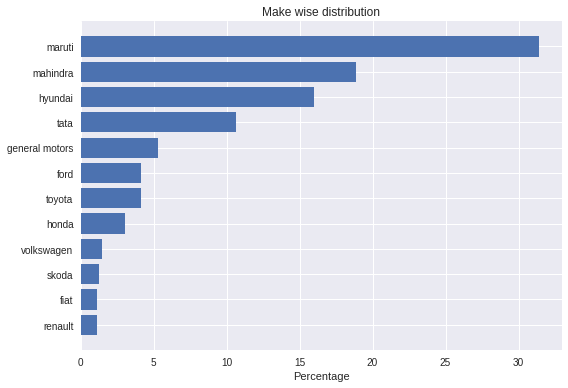

In [23]:
def plot_vc(dataset,col,title):
  plt.style.use('seaborn')
  x=dataset[col].value_counts()
  x=x.reset_index()
  x[col]=100*x[col]/sum(x[col])
  x=x.sort_values(col)
  x=x[x[col]>1]
  plt.barh(x['index'],x[col])
  plt.title(title)
  plt.xlabel('Percentage')
  plt.tight_layout()
  plt.show()
  
# plot_vc(master_df,'Data Origin','how customers know abt MFCS')
plot_vc(master_df,'Make','Make wise distribution')
# plot_vc(master_df,'State','State wise distribution')
# plot_vc(master_df[master_df['State'] == 'maharashtra'],'CITY','Citywise distribution in maharashtra')
# plot_vc(master_df[master_df['State'] == 'tamil nadu'],'CITY','Citywise distribution in TN')
# plot_vc(master_df,'Order Type','Order type distribution')
# plot_vc(master_df[master_df['State'] == 'maharashtra'],'Plant Name1','plant wise distribution in maharashtra')

In [24]:
print("columns from invoice_df: ",set(master_df.columns) & set(invoice_df.columns))
print("columns from customer_df: ",set(master_df.columns) & set(customer_df.columns))
print("columns from plant_df: ",set(master_df.columns) & set(plant_df.columns))
print("columns from vehicles_df: ",set(master_df.columns) & set(vehicles_df.columns))

columns from invoice_df:  {'Cust Type', 'Print Status', 'Customer No.', 'Model', 'Job Card No', 'Pin code', 'KMs Reading', 'CITY', 'Make', 'Invoice No', 'User ID', 'Order Type', 'Gate Pass Time', 'State', 'Plant', 'Regn No', 'Labour Total'}
columns from customer_df:  {'Data Origin', 'Title', 'Partner Type', 'Customer No.', 'Business Partner'}
columns from plant_df:  {'Plant', 'Sales organization', 'State'}
columns from vehicles_df:  {'Regn No', 'Make', 'Fuel Type'}


        Fuel Type  Total_Expense  counts
388504          2        6901.28       1
89676           1        3524.05       1
502303          2       26235.15       1


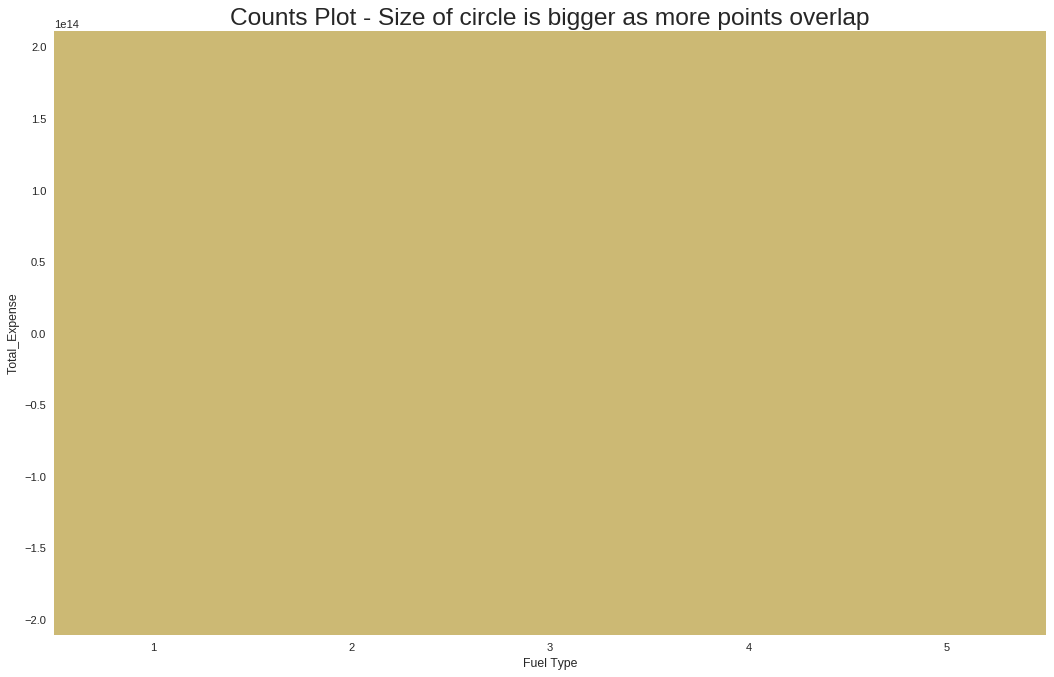

In [25]:
df_counts = master_df.groupby(['Fuel Type', 'Total_Expense']).size().reset_index(name='counts')
print(df_counts.sample(3))
# Draw Stripplot
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)    
sns.stripplot(df_counts['Fuel Type'], df_counts.Total_Expense, size=df_counts.counts*2, ax=ax)

# Decorations
plt.title('Counts Plot - Size of circle is bigger as more points overlap', fontsize=22)
plt.show()

In [26]:
master_df['Make'].unique()

array(['hyundai', 'mahindra', 'tata', 'maruti', 'toyota',
       'general motors', 'skoda', 'ford', 'honda', 'fiat', 'volkswagen',
       'mitsubishi motor', 'hindustan motors', 'audi', 'nissan', 'daewoo',
       'mercedes-benz', 'bmw', 'renault', 'volvo', 'force', 'rover',
       'sonalika', 'premierauto', 'jeep', 'porsche', 'san motors',
       'morris'], dtype=object)

In [0]:
# # Prepare data
# x_var = 'Fuel Type'
# groupby_var = 'Total_Expense'
# df_agg = master_df.loc[:, [x_var, groupby_var]].groupby(groupby_var)
# vals = [master_df[x_var].values.tolist() for i, df in df_agg]

# # Draw
# plt.figure(figsize=(16,9), dpi= 80)
# colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
# n, bins, patches = plt.hist(vals, master_df[x_var].unique().__len__(), stacked=True, density=False, color=colors[:len(vals)])

# # Decoration
# plt.legend({group:col for group, col in zip(np.unique(master_df[groupby_var]).tolist(), colors[:len(vals)])})
# plt.title(f"Stacked Histogram of ${x_var}$ colored by ${groupby_var}$", fontsize=22)
# plt.xlabel(x_var)
# plt.ylabel("Frequency")
# plt.ylim(0, 40)
# plt.xticks(ticks=bins, labels=np.unique(master_df[x_var]).tolist(), rotation=90, horizontalalignment='left')
# plt.show()

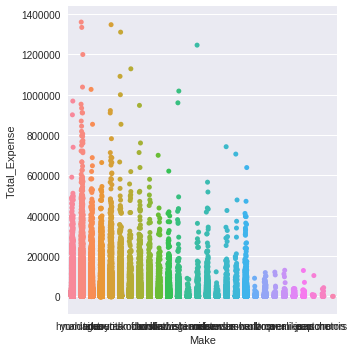

In [28]:
sns.catplot(y="Total_Expense", x="Make", data=master_df);

In [29]:
master_df.columns

Index(['CITY', 'Cust Type', 'Customer No.', 'State', 'Gate Pass Time',
       'Invoice No', 'Job Card No', 'KMs Reading', 'Labour Total', 'Make',
       'Model', 'Order Type', 'Pin code', 'Plant', 'Print Status', 'Regn No',
       'User ID', 'Business Partner', 'Partner Type', 'Data Origin', 'Title',
       'Sales organization', 'Fuel Type', 'Invoice Date-Invoice Time',
       'JobCard Date-JobCard Time', 'Year', 'Month', 'Job_duration(in days)',
       'Total_Expense'],
      dtype='object')

In [30]:
master_df[categorical_columns_master_df].describe()

,CITY,Cust Type,Customer No.,State,Gate Pass Time,Make,Model,Order Type,Plant,Print Status,Regn No,User ID,Business Partner,Partner Type,Data Origin,Sales organization,Invoice Date-Invoice Time,JobCard Date-JobCard Time
count,980337,980337,980337,980337,980337,980337,980337,980337,980337,980337,980337,980337,980337,980337,980337,980337,980337,980337
unique,26884,5,501724,36,25420,28,255,9,431,2,514076,934,501724,7,22,5,957382,955102
top,chennai,retail,e4981,tamil nadu,00:00:00,maruti,swift,running repairs,bc03,no,mh04dn6210,bc03sa2,e4981,Retail,Ref-Customer,mfcd,2017-07-10 17:59:13,2017-01-30 13:06:11
freq,44243,978565,2871,190739,934842,307662,64801,551249,28772,934842,156,10042,2871,978647,248326,776305,9,6
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-04-02 17:04:33,2012-04-01 16:14:12
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-31 23:23:16,2017-12-31 23:16:21


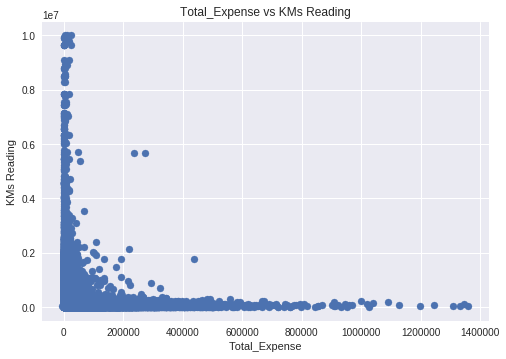

In [31]:
def scatter_plot(df,x,y):
  plt.style.use('seaborn')
  plt.scatter(df[x],df[y])
  #cbar=plt.colorbar()
  #cbar.set_label('Price variation')
  plt.xlabel(x)
  plt.ylabel(y)
  plt.title('{} vs {}'.format(x,y))
  plt.show()

scatter_plot(master_df,'Total_Expense','KMs Reading')

Index(['fiat', 'ford', 'general motors', 'honda', 'hyundai', 'mahindra',
       'maruti', 'renault', 'skoda', 'tata', 'toyota', 'volkswagen'],
      dtype='object', name='Make')


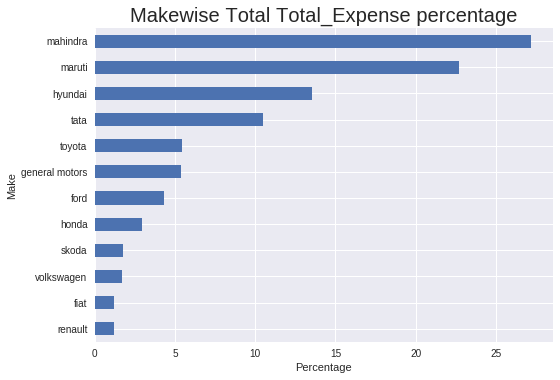

In [32]:
def plot_groupby(df,col1,col2):
  gp=df.groupby(col1)[col2].sum()
  gp=100*gp/sum(gp)
  gp=gp[gp>1]
  print(gp.index)
  gp.sort_values().plot(kind='barh')
  plt.style.use('fivethirtyeight')
  plt.title('{}wise Total {} percentage'.format(col1,col2))
  plt.xlabel('Percentage')
  plt.tight_layout()

plot_groupby(master_df,'Make','Total_Expense')

In [0]:
master_df1 = master_df

In [0]:
not_corrected =[]
digits = []

def spellcorrect(string):
      spell = SpellChecker()
      spell.word_frequency.load_words(['chennai', 'bangalore'])
      if (string.isdigit()):
          digits.append(string)
      elif (len(string.split())<=2) :
          if (len(spell.candidates(string))==1):
              string = spell.correction(string)
      else:
          not_corrected.append(string)
      return string
          
def typo_check(dataset,col): 
    dataset[col] = dataset[col].apply(spellcorrect)
    return dataset
  
master_df1 = typo_check(master_df1, 'CITY')

not_corrected

In [0]:


# master_df.to_csv('master.csv', index=False)
# files.download('master.csv')